In [8]:
import os
#import sys
#sys.path.append('../../notebooks/')
from modulos.sensormtx import *
import modulos.iluminacion_osrad as ill
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from dateutil.parser import parse
# mpl.rcParams['path.simplify'] = True
# mpl.rcParams['path.simplify_threshold'] = 0.5  # 0–1 aprox.; prueba 0.1–0.6
import pyarrow.parquet as pq


In [2]:
# Posición de sensores:
#A10 = sensormtx(24.24,31.64,0,4.316,40,70,10.0)
#A102 = sensormtx(40.24,47.64,0,4.316,40,70,10.0)
#A20 = sensormtx(40.24,31.64,6.465,12.13,70,60,10.0)
#A202 = sensormtx(40.24,47.64,6.465,12.13,70,60,10.0)
# a40 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# a40 = ill.daylight("../resultados/iluminancia/A40-1_anual.ill",a40)
# f = "../resultados/iluminancia/A40-1_anual.ill"
# ill_a40 = np.loadtxt(f,skiprows=10).reshape(100,120,365,24).transpose(2,3,0,1)
#A402 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# rutas de resultados: '../resultados/{AULA}_anual.ill'
# AULA -> A10-1, A10-2, A20-1, A20-2, A40-1, A40-2

In [3]:
# a40 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# a40 = ill.daylight("../resultados/iluminancia/A40-1_anual.ill",a40)
f = "../resultados/iluminancia/A40-1_anual.ill"
ill_a40_1 = np.loadtxt(f,skiprows=10).reshape(100,120,366,24).transpose(2,3,0,1)


In [12]:
np.savez_compressed("test.npyz",ill_a40_1)

In [4]:
# a40_2 = sensormtx(24.30,31.70,2.535,12.13,120,100,5.45)
# a40 = ill.daylight("../resultados/iluminancia/A40-2_anual.ill",a40)
f = "../resultados/iluminancia/A40-2_anual.ill"
ill_a40_2 = np.loadtxt(f,skiprows=10).reshape(100,120,366,24).transpose(2,3,0,1)

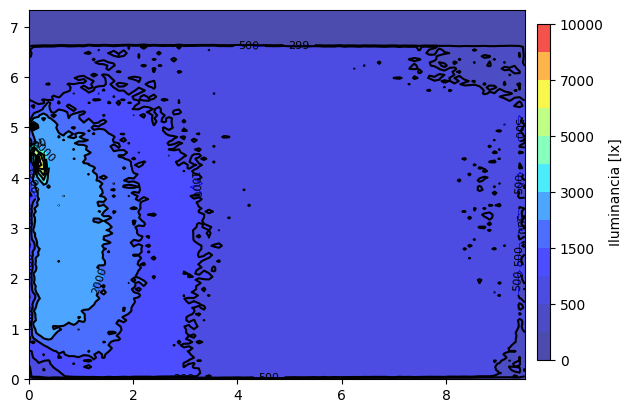

In [39]:
fig, ax = plt.subplots()

f1 = parse("2024-06-26")
f1 = pd.to_datetime(f1)
day = f1.dayofyear

hour = 10
nx = 100
ny = 120
mapa = ill_a40_2[day,hour].T[::1,::-1]
dx, dy = 0.09595, 0.061666666666666654   # espaciamientos en X y Y
x0, y0 = 0.0, 0.0
x = x0 + np.arange(nx) * dx
y = y0 + np.arange(ny) * dy
X, Y = np.meshgrid(x, y)
niveles = [0, 299, 500, 1000, 1500, 2000, 3000,4000,5000,6000,7000,8000,10000]

contour_filled = ax.contourf(X,Y,mapa,levels=niveles,cmap="jet",alpha=0.7)
contour = ax.contour(X, Y, mapa, colors='black', levels=niveles)
ax.clabel(contour, inline=True, fontsize=8)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Definir la posición de la barra de color
fig.colorbar(contour_filled, cax=cbar_ax, label='Iluminancia [lx]')
